# Breast Cancer Diagnosis

In this notebook we will apply the LogitBoost algorithm to a toy dataset to classify cases of breast cancer as benign or malignant.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', color_codes=True)

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE

from logitboost import LogitBoost

## Loading the Data

The breast cancer dataset imported from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) contains 569 samples with 30 real, positive features (including cancer mass attributes like mean radius, mean texture, mean perimeter, et cetera).
Of the samples, 212 are labeled "malignant" and 357 are labeled "benign".
We load this data into a 569-by-30 feature matrix and a 569-dimensional target vector.
Then we randomly shuffle the data and designate two thirds for training and one third for testing.

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target_names[data.target]
n_classes = data.target.size

# Shuffle data and split it into training/testing samples
test_size = 1 / 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    shuffle=True, stratify=y,
                                                    random_state=0)

## Visualizing the Training Set

Although the features are 30-dimensional, we can visualize the training set by using [t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE) to project the features onto a 2-dimensional space.

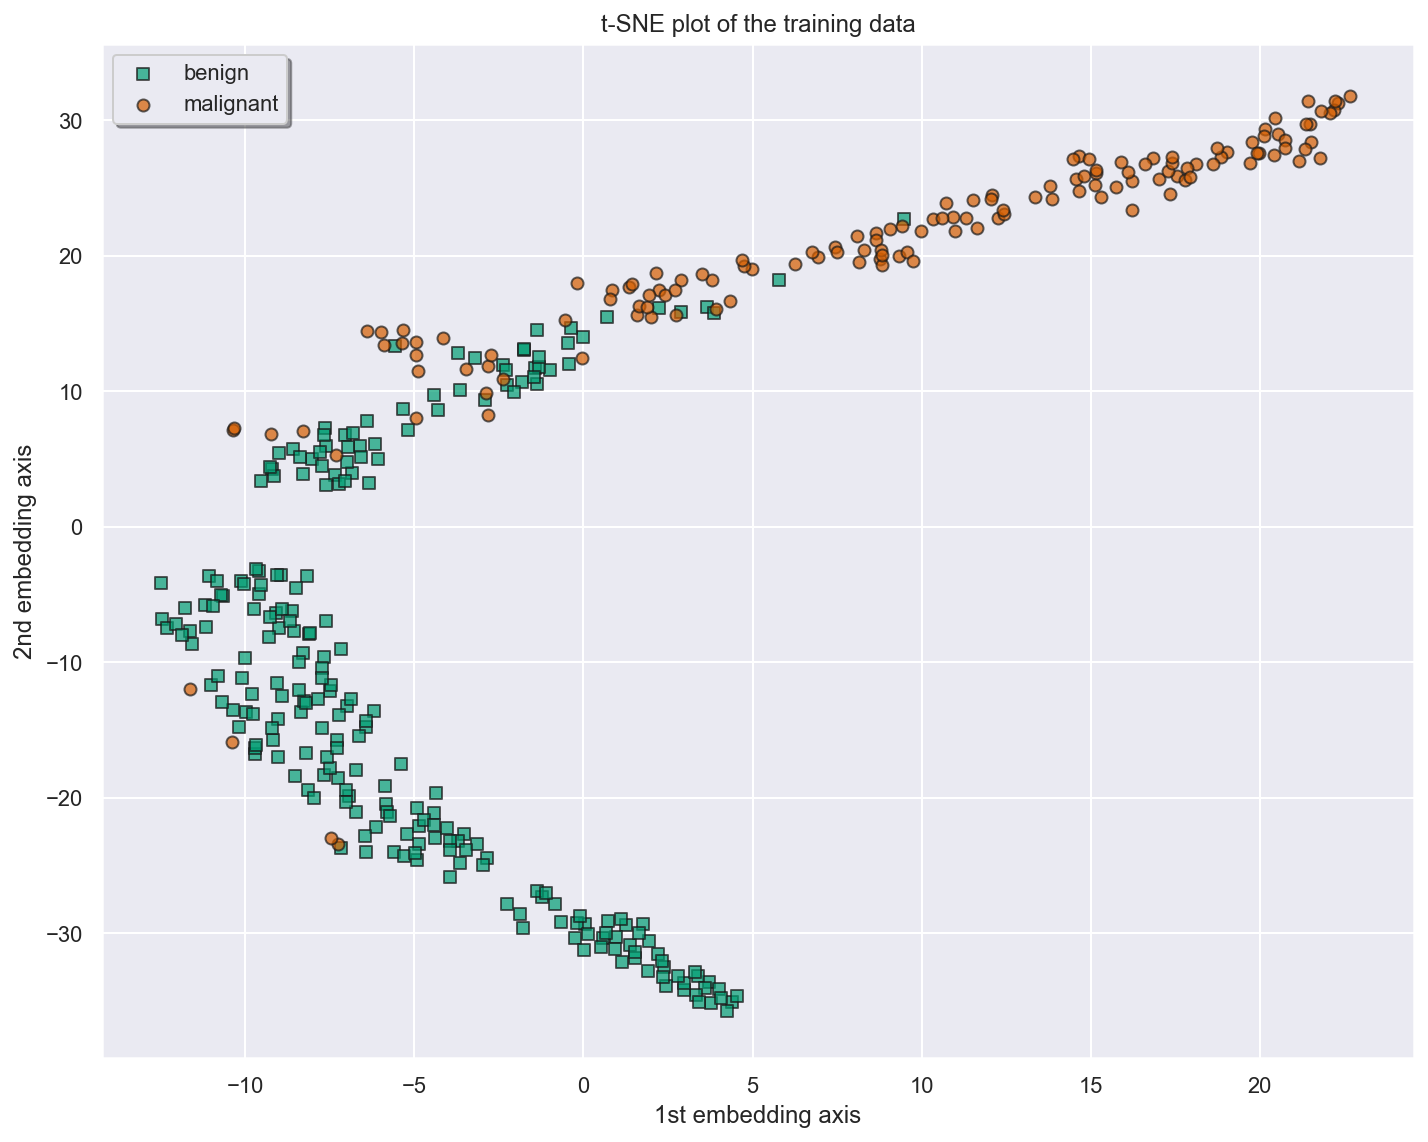

In [3]:
tsne = TSNE(n_components=2, random_state=0)
X_train_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 8))
mask_benign = (y_train == 'benign')
mask_malignant = (y_train == 'malignant')

plt.scatter(X_train_tsne[mask_benign, 0], X_train_tsne[mask_benign, 1],
           marker='s', c='g', label='benign', edgecolor='k', alpha=0.7)
plt.scatter(X_train_tsne[mask_malignant, 0], X_train_tsne[mask_malignant, 1],
           marker='o', c='r', label='malignant', edgecolor='k', alpha=0.7)


plt.title('t-SNE plot of the training data')
plt.xlabel('1st embedding axis')
plt.ylabel('2nd embedding axis')
plt.legend(loc='best', frameon=True, shadow=True)

plt.tight_layout()
plt.show()
plt.close()

## Fitting the LogitBoost Model

Next, we initialize a LogitBoost classifier and fit it to the training data.
By default, LogitBoost uses decision stumps (decision trees with depth 1, i.e., a single split) as its base estimator.

In [4]:
lboost = LogitBoost(n_estimators=200, random_state=0)
lboost.fit(X_train, y_train)

LogitBoost(base_estimator=None, bootstrap=False, learning_rate=1.0,
           max_response=4.0, n_estimators=200, random_state=0,
           weight_trim_quantile=0.05)

## Prediction Accuracy

As a first indicator of how well the model predicts the correct labels, we can check its accuracy score (number of correct predictions over the number of total predictions) on the training and test data.
If the classifier is good, then the accuracy score should be close to 1.

In [5]:
y_pred_train = lboost.predict(X_train)
y_pred_test = lboost.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print('Training accuracy: %.4f' % accuracy_train)
print('Test accuracy:     %.4f' % accuracy_test)

Training accuracy: 0.9947
Test accuracy:     0.9737


## Precision and Recall

We can also report our LogitBoost model's [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).

In [6]:
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)
print('Training\n%s' % report_train)
print('Testing\n%s' % report_test)

Training
              precision    recall  f1-score   support

      benign       0.99      1.00      1.00       238
   malignant       1.00      0.99      0.99       141

    accuracy                           0.99       379
   macro avg       1.00      0.99      0.99       379
weighted avg       0.99      0.99      0.99       379

Testing
              precision    recall  f1-score   support

      benign       0.97      0.98      0.98       119
   malignant       0.97      0.96      0.96        71

    accuracy                           0.97       190
   macro avg       0.97      0.97      0.97       190
weighted avg       0.97      0.97      0.97       190



## Visualizing Accuracy During Boosting

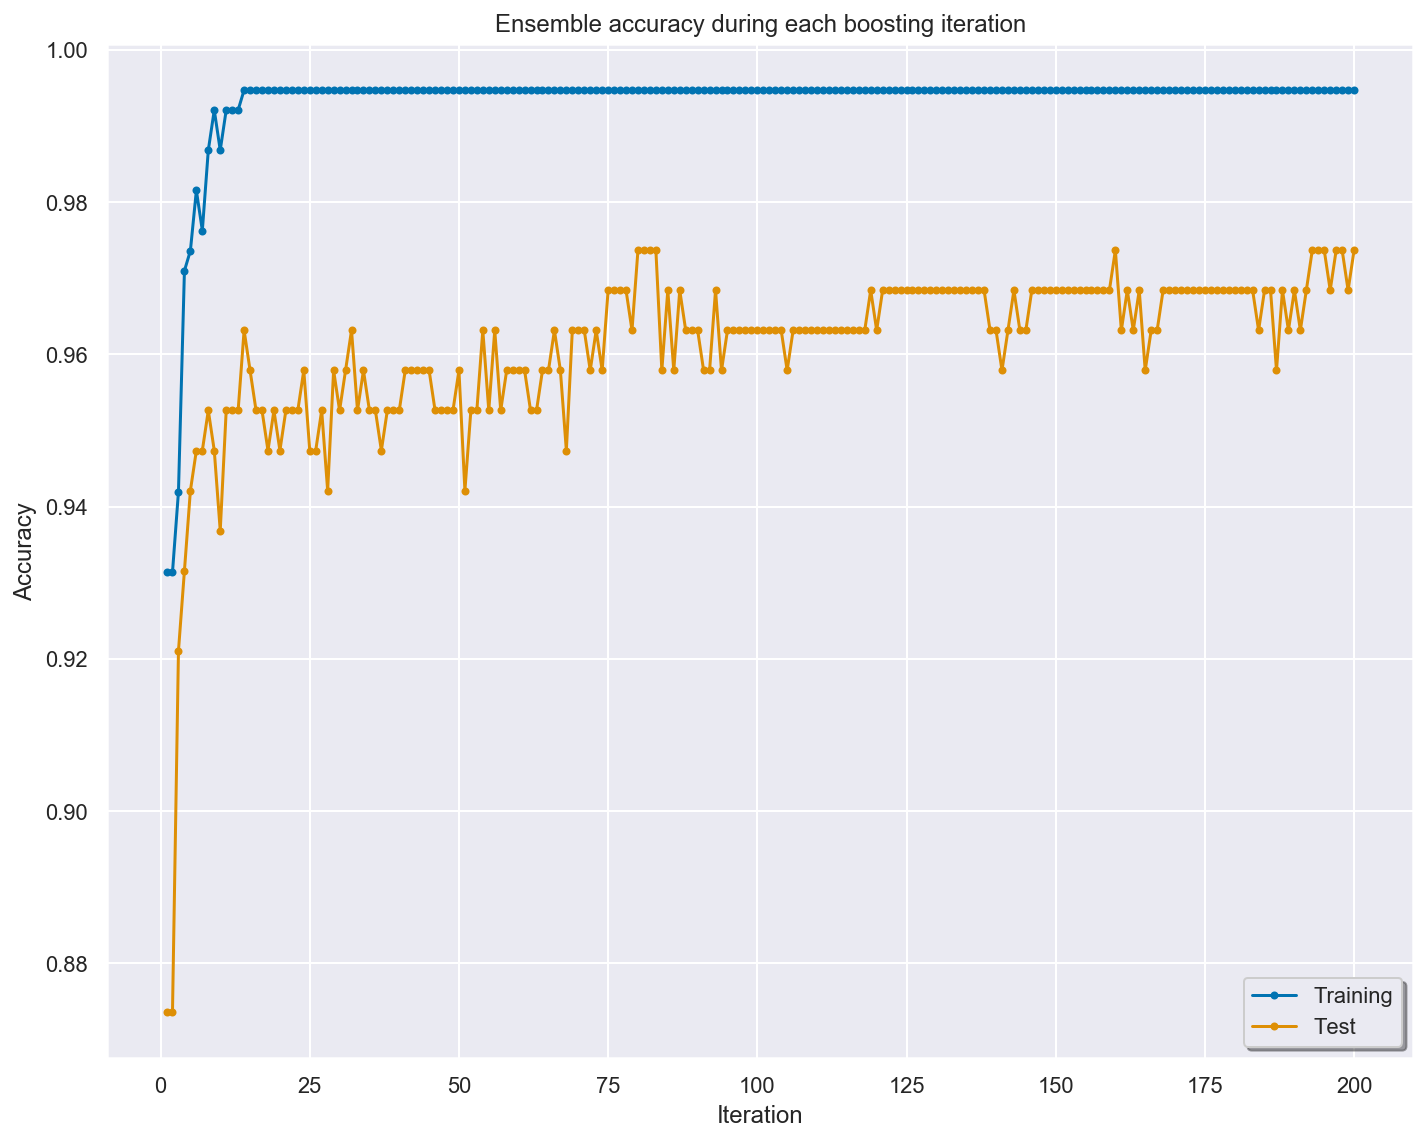

In [7]:
iterations = np.arange(1, lboost.n_estimators + 1)
staged_accuracy_train = list(lboost.staged_score(X_train, y_train))
staged_accuracy_test = list(lboost.staged_score(X_test, y_test))

plt.figure(figsize=(10, 8))
plt.plot(iterations, staged_accuracy_train, label='Training', marker='.')
plt.plot(iterations, staged_accuracy_test, label='Test', marker='.')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Ensemble accuracy during each boosting iteration')
plt.legend(loc='best', shadow=True, frameon=True)

plt.tight_layout()
plt.show()
plt.close()

## Contribution of Each Estimator in the Ensemble

Like other ensemble models, the LogitBoost model can suffer from *over-specialization*: estimators added to the ensemble in later boosting iterations make relatively small or even negligible contributions toward improving the overall predictions on the training set.
This can be quantified by computing the mean of the absolute prediction of each estimator in the ensemble taken over the training set.

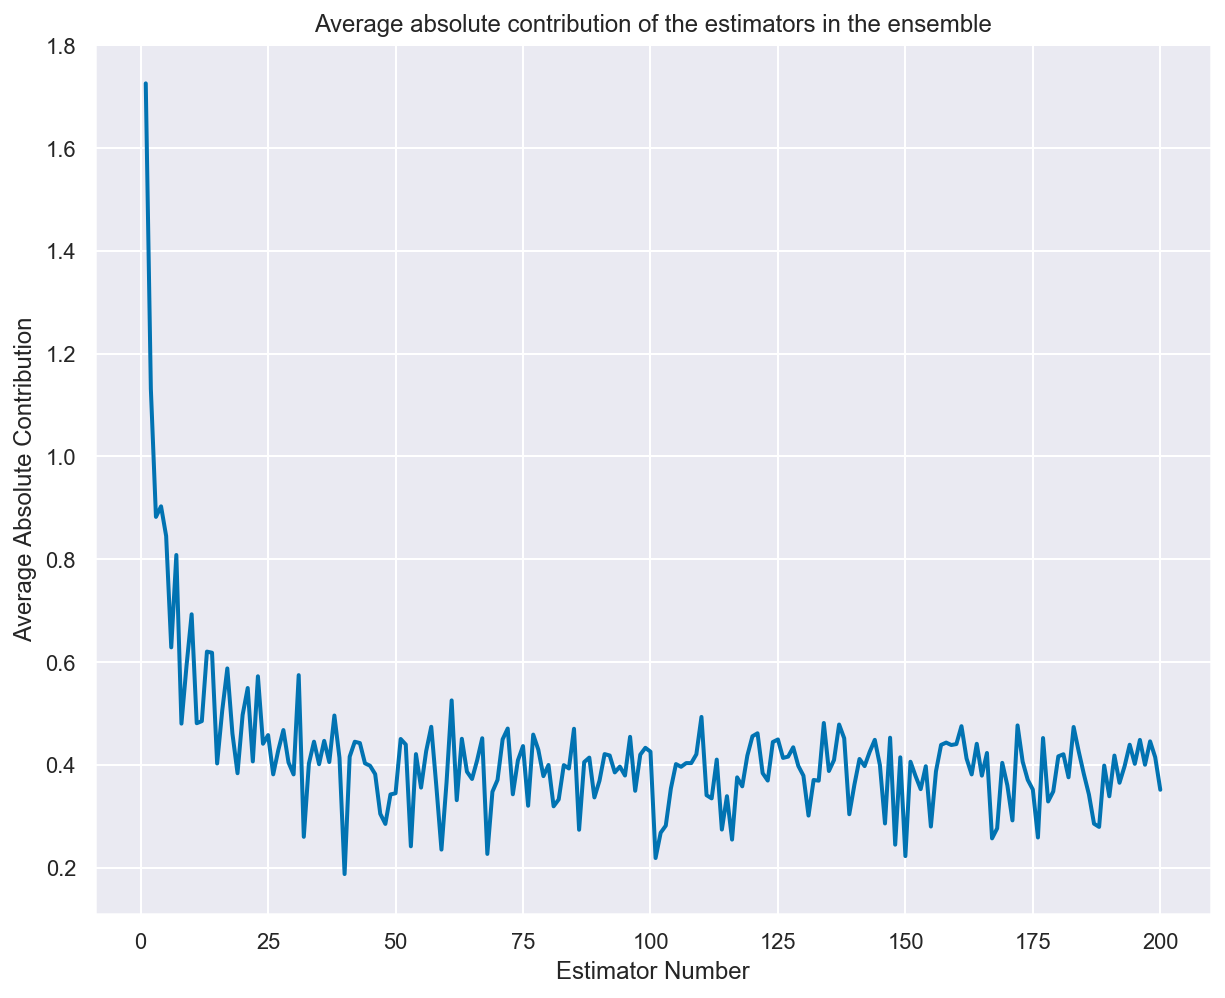

In [8]:
contrib_train = lboost.contributions(X_train)

plt.figure(figsize=(10, 8))
plt.plot(iterations, contrib_train, lw=2)
plt.xlabel('Estimator Number')
plt.ylabel('Average Absolute Contribution')
plt.title('Average absolute contribution of the estimators in the ensemble')
plt.show()
plt.close()

## Appendix: System Information

This is included for replicability.

In [9]:
# sys_info.py is a file in the same directory as these example notebooks:
# doc/source/examples
import sys_info


Machine
      Platform: Darwin-18.7.0-x86_64-i386-64bit
  Machine Type: x86_64
     Processor: i386

Python
       Version: 3.7.2 (v3.7.2:9a3ffc0492, Dec 24 2018, 02:44:43) 
                [Clang 6.0 (clang-600.0.57)]
Implementation: CPython

Packages
         numpy: 1.17.2
         scipy: 1.3.1
    matplotlib: 3.1.1
       seaborn: 0.9.0
       sklearn: 0.21.3
